## 물류 유통량 예측

### 1. 데이터 불러오기 및 전처리
---

In [ ]:
# 한글 폰트 설치 후 런타임 재시작 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,194 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

# 경로 설정(정보 생략)
import os
os.chdir()
os.getcwd()

In [ ]:
# Data read
import pandas as pd 
df = pd.read_csv('chatper21_logistic.csv', encoding='cp949') # 한글이 포함된 파일이기 때문에 utf-8이나 cp949로 인코딩 설정
df.head(10)

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3
5,5,5013000778073200,4159000114016400,농산물,6
6,6,5011000316024300,4827000369060200,수산,5
7,7,5013000740006400,4111700017039400,농산물,3
8,8,4136000209094100,5013000823053400,아우터,3
9,9,5011000315056100,4127100026035200,농산물,8


In [ ]:
# Data 형태 확인
print('df', df.shape) # 31,684, 5

df (31684, 5)


In [ ]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         31684 non-null  int64 
 1   송하인_격자공간고유번호  31684 non-null  int64 
 2   수하인_격자공간고유번호  31684 non-null  int64 
 3   물품_카테고리       31684 non-null  object
 4   운송장_건수        31684 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [ ]:
# Null 값 확인
print(df.isnull().sum())

index           0
송하인_격자공간고유번호    0
수하인_격자공간고유번호    0
물품_카테고리         0
운송장_건수          0
dtype: int64


In [ ]:
# Outlier 확인
df.describe()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,운송장_건수
count,31684.000000,3.168400e+04,3.168400e+04,31684.000000
mean,15841.500000,4.648814e+15,3.801369e+15,4.879308
std,9146.527301,8.341336e+14,1.314660e+15,6.756473
min,0.000000,1.111000e+15,1.111000e+15,3.000000
25%,7920.750000,4.713000e+15,2.826000e+15,3.000000
50%,15841.500000,5.011000e+15,4.159000e+15,3.000000
75%,23762.250000,5.013001e+15,5.011000e+15,5.000000
max,31683.000000,5.013001e+15,5.013001e+15,413.000000


#### 1) 배송 지역 탐색


In [ ]:
df.head(5)

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [ ]:
# Col rename
df.columns = ['index', 'start', 'end', 'prod', 'cnt']
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [ ]:
# 배송 출발지 4,229개소
df['start'].value_counts()

5011000078068400    3882
5013000610049100    1790
5013000731055200    1235
5011000137030100    1137
5013000821028200     731
                    ... 
4511300030055300       1
4719000321023400       1
4423000423020300       1
4711300748080100       1
2811000139076100       1
Name: start, Length: 4229, dtype: int64

In [ ]:
# 배송 도착지 26,875개소, 출발지보다 배송지의 지역이 더 많음
df['end'].value_counts()

5013000635005300    35
5011000543041100    33
5011000314069300    33
5011000544072300    30
5011000318044100    30
                    ..
5011000109040100     1
4183000550093100     1
4425000028078200     1
1147000011064300     1
5011000263065200     1
Name: end, Length: 26875, dtype: int64

In [ ]:
# 총 지역(출발+배송) 30,455개
all_list = list(df['start']) + list(df['end'])
unique_list = set(all_list)
len(unique_list)

30455

#### 2) 물품 카테고리 탐색


In [ ]:
# 물품의 종류 탐색(총 100개의 물품 카테고리)
df['prod'].value_counts()

농산물              20321
문화컨텐츠             1091
음료                1034
수산                 860
가공식품               846
                 ...  
유아가구                 4
기타출산/육아              4
태블릿PC/노트북액세서리        4
선케어                  4
스포츠잡화                4
Name: prod, Length: 100, dtype: int64

In [ ]:
# 운송장 건수 기준, 내림차순 정렬
df_cnt = df.groupby('prod', as_index=False)['cnt'].sum()
df_cnt = df_cnt.sort_values(by=['cnt'], ascending = False)
df_cnt.head(10)

,prod,cnt
27,농산물,87829
66,음료,5890
3,가공식품,5766
34,문화컨텐츠,5429
51,수산,4880
17,기타식품,4250
5,건강식품,3413
80,축산,3385
19,기타패션의류,3042
67,음반,2357


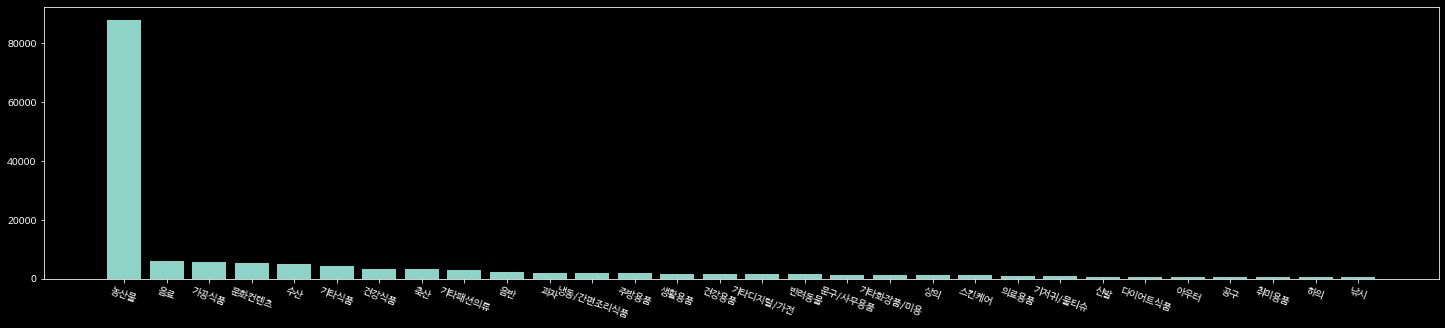

In [ ]:
# 운송장 건수 기준, 내림차순 정렬 Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.rc('font', family='NanumBarunGothic') 
plt.bar(df_cnt['prod'][0:30], df_cnt['cnt'][0:30], label='cnt');
plt.xticks(rotation =-20);
plt.gcf().set_size_inches(25, 5);

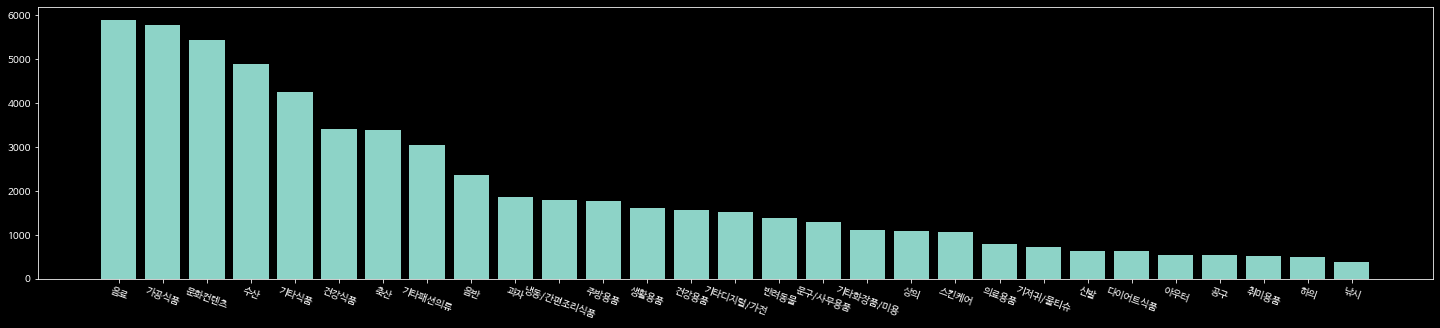

In [ ]:
# 운송장 건수 기준, 내림차순 정렬 Plotting(농산물 제거)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.rc('font', family='NanumBarunGothic') 
plt.bar(df_cnt['prod'][1:30], df_cnt['cnt'][1:30], label='cnt');
plt.xticks(rotation =-20);
plt.gcf().set_size_inches(25, 5);

### 2. 지역별 유통량 분석
---

In [ ]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


#### 1) 출발지/도착지 분석


In [ ]:
# 가장 많이 배송이 출발하는 지역(운송장 건수 기준)
df_start = df.groupby(['start'], as_index=False)['cnt'].sum()
df_start = df_start.sort_values(by=['cnt'], ascending = False)
df_start

,start,cnt
2398,5011000078068400,14391
3686,5013000610049100,6439
3784,5013000731055200,4579
2448,5011000137030100,4054
1471,4148000690015300,3064
...,...,...
3189,5011000476040200,3
1910,4375000376047100,3
1911,4376000055095100,3
1912,4376000239100300,3


In [ ]:
# 출발지 기준 상위 600개의 장소에서 전체 배송건수에 80%이상을 조달함
df_start['cnt'].head(600).sum() / df_start['cnt'].sum()

0.8018512768765039

In [ ]:
# 가장 많이 배송이 도착하는 지역(운송장 건수 기준)
df_end = df.groupby(['end'], as_index=False)['cnt'].sum()
df_end = df_end.sort_values(by=['cnt'], ascending = False)
df_end

,end,cnt
21857,5011000168096300,429
23295,5011000314069300,400
25076,5011000543041100,331
24149,5011000373020100,267
23602,5011000318041400,261
...,...,...
11376,4122000434074100,3
11374,4122000431067300,3
11369,4122000403096400,3
11368,4122000403084400,3


In [ ]:
# 도착지 기준 상위 17000개의 장소에서 전체 배송건수에 80%이상을 조달함
df_end['cnt'].head(17000).sum() / df_end['cnt'].sum()

0.8083714973220523

In [ ]:
df_start_end = pd.DataFrame({'start' : df_start['cnt'], 'end': df_end['cnt']})
df_start_end.fillna(0, inplace = True)
df_start_end['total'] = df_start_end['start'] + df_start_end['end']
df_start_end.head(5)

,start,end,total
0,5.0,4,9.0
1,7.0,3,10.0
2,22.0,3,25.0
3,3.0,3,6.0
4,13.0,3,16.0


In [ ]:
# 출발 및 배송 건수가 가장 많은 지역
df_start_end.sort_values(by=['total'], ascending = False).head(10)

,start,end,total
2398,14391.0,4,14395.0
3686,6439.0,4,6443.0
3784,4579.0,4,4583.0
2448,4054.0,3,4057.0
1471,3064.0,5,3069.0
3980,2732.0,3,2735.0
3875,2356.0,3,2359.0
3163,1949.0,3,1952.0
1292,1825.0,3,1828.0
2547,1787.0,5,1792.0


#### 2) 유통경로 분석

In [ ]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [ ]:
# 가장 많이 배송되는 유통경로(운송장 건수 기준)
df_route = df.groupby(['start', 'end'], as_index=False)['cnt'].sum()
df_route = df_route.sort_values(by=['cnt'], ascending = False)
df_route.head(10)

,start,end,cnt
2260,4117300018005400,5011000168096300,413
2267,4117300018005400,5011000318041400,239
2266,4117300018005400,5011000315073100,211
7068,4413300143027400,5011000214015400,197
2264,4117300018005400,5011000214005200,195
24131,5013000619074300,2641000022056100,179
20968,5013000055030400,4183000267092400,164
7069,4413300143027400,5011000315073200,164
2265,4117300018005400,5011000313002100,160
2263,4117300018005400,5011000211098300,151


In [ ]:
# 유통경로 기준 상위 2100개의 경로에서 전체 배송건수에 80%이상을 조달함
df_route['cnt'].head(21000).sum() / df_route['cnt'].sum()

0.8007645734689125

In [ ]:
# 해당 경로로 배송된 물품은 모두 '기타패션의류'
# 경로 기준으로 카테고리화 가능
df[(df['start']==4117300018005400) & (df['end']==5011000168096300)]

,index,start,end,prod,cnt
25394,25394,4117300018005400,5011000168096300,기타패션의류,413


In [ ]:
# 해당 경로로 배송된 물품은 모두 '신발'
df[(df['start']==4413300143027400) & (df['end']==5011000214015400)]

,index,start,end,prod,cnt
3898,3898,4413300143027400,5011000214015400,신발,197


In [ ]:
# 특히 출발지에 따라 물품이 다름
df[(df['start']==4117300018005400)]

,index,start,end,prod,cnt
3772,3772,4117300018005400,5011000169044300,기타패션의류,17
7421,7421,4117300018005400,5011000211098300,기타패션의류,151
8136,8136,4117300018005400,5011000313002100,기타패션의류,160
8262,8262,4117300018005400,5011000211085400,기타패션의류,105
11280,11280,4117300018005400,5011000374024200,기타패션의류,72
17281,17281,4117300018005400,5011000315073100,기타패션의류,211
19408,19408,4117300018005400,5011000168095300,기타패션의류,42
24463,24463,4117300018005400,5011000214005200,기타패션의류,195
25394,25394,4117300018005400,5011000168096300,기타패션의류,413
30090,30090,4117300018005400,5011000318041400,기타패션의류,239


#### 3) 출발지 기준 배차분석

In [ ]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [ ]:
# 출발 지역에서 가장 많이 배송되는 물품을 대표 물품으로 정의
pd.DataFrame(df[df['start']==4141000031030100].groupby('prod')['cnt'].sum().sort_values(ascending=False)).reset_index().head(1)

,prod,cnt
0,건강용품,468


In [ ]:
# 모든 출발 배송 지역에 대해서 상위 조건을 수행하기 위한 for문 작성
list_of_df = [] 

for i in list(df['start'].unique()) :
  loop_df = pd.DataFrame(df[df['start']==i].groupby('prod')['cnt'].sum().sort_values(ascending=False)).reset_index().head(1)
  loop_df['id'] = i
  list_of_df.append(loop_df)

df_accum_start = pd.concat(list_of_df) 

In [ ]:
df_accum_start

,prod,cnt,id
0,음반,1652,5011000595017300
0,문화컨텐츠,383,4148000690043300
0,농산물,14380,5011000078068400
0,기타식품,96,4127100048006400
0,농산물,492,5013000778073200
...,...,...,...
0,기타패션잡화,9,4113300019005400
0,침구세트,4,4873000294001400
0,기타패션잡화,105,2638000008087200
0,스마트디바이스액세서리,3,1120000013030100


In [ ]:
# 물품별 전체 배송량 데이터 생성 
df_prod_sum = pd.DataFrame(df.groupby('prod', as_index = False)['cnt'].sum())
df_prod_sum.columns = ['prod', 'total']
df_prod_sum.head(5)

,prod,total
0,DIY자재/용품,150
1,PC,200
2,PC주변기기,30
3,가공식품,5766
4,가방,26


In [ ]:
# 출발지 기준 물품 배송량에 left join
df_merge = pd.merge(df_accum_start, df_prod_sum, how='left', on='prod')
df_merge = df_merge[['id', 'prod', 'cnt', 'total']]
df_merge.head(5)

,id,prod,cnt,total
0,5011000595017300,음반,1652,2357
1,4148000690043300,문화컨텐츠,383,5429
2,5011000078068400,농산물,14380,87829
3,4127100048006400,기타식품,96,4250
4,5013000778073200,농산물,492,87829


In [ ]:
# 전체 물품 배송량 중 몇 퍼센트를 싣고 떠나는지 분석을 통해 차량 배차가 가능해짐
df_merge['ratio'] = df_merge['cnt'] / df_merge['total']
df_merge.head(5)

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
1,4148000690043300,문화컨텐츠,383,5429,0.070547
2,5011000078068400,농산물,14380,87829,0.163727
3,4127100048006400,기타식품,96,4250,0.022588
4,5013000778073200,농산물,492,87829,0.005602


In [ ]:
# 전체 물품 중 적어도 50% 이상을 출발시키는 곳에 특성 배차를 할 수 있을 것으로 가정(총 16개 출발지를 특성 배차 지역으로 선정)
df_merge[df_merge['ratio'] > 0.50]

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
57,4148000427007400,출산/유아동의류,23,30,0.766667
70,4148000690015300,문화컨텐츠,3064,5429,0.564376
96,1117000009037100,기타디지털/가전,837,1505,0.556146
359,4127300022051100,위생/건강용품,135,249,0.542169
457,5011000320025200,네일케어,35,69,0.507246
584,4873000228047300,낚시,316,386,0.818653
596,4150000196034300,다이어트식품,419,619,0.676898
1109,4117300018005400,기타패션의류,1605,3042,0.527613
1129,4413300143027400,신발,392,637,0.615385


### 3. ML 활용 유통량 예측
---

In [ ]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [ ]:
# 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

X=df.drop(['index', 'cnt'], axis=1)
Y=df['cnt']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1239)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(19010, 3)
(19010,)
(12674, 3)
(12674,)


In [ ]:
# One hot encoder는 물품 종류가 많은 관계로 차원 수가 너무 많아져서 모형의 성능을 떨어트릴 수 있음
# Label encoder는 회귀 관련 알고리즘을 사용할 때는 순서에 따른 영향도에 따라 노이즈가 될 수 있으므로 사용 X(트리 기반 알고리즘은 사용해도 OK!)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(x_train['prod'].values) + list(x_test['prod'].values))
x_train['prod'] = le.transform(x_train['prod'])
x_test['prod'] = le.transform(x_test['prod'])

In [ ]:
x_test['prod'].head(5)

17822    27
2269     51
37       27
24369    27
17187    27
Name: prod, dtype: int64

#### 1) 모델 학습 및 평가

In [ ]:
# 처음에 과적합을 시켜 모형을 만들고 평가 지표에 따라 점차 낮춰서 적합한 하이퍼 파라미터 설정
rfr = RandomForestRegressor(n_estimators=300, max_depth=8)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=300)

In [ ]:
# 예측
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae): ', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_score(r2): ', r2_train)
print('')
mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_score(r2): ', r2_test)

mae_train(mae):  2.2027521974521433
r2_score(r2):  0.2971145801229462

mae_test(mae):  2.3011581645115986
r2_score(r2):  0.2307724051671992


In [ ]:
pd.options.display.float_format = '{:.5f}'.format
result = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred_test})
result['diff'] = result['Real Values'] - result['Predicted Values']
result.head(10)

,Real Values,Predicted Values,diff
17822,3,3.93519,-0.93519
2269,10,5.48974,4.51026
37,3,3.64810,-0.64810
24369,12,4.20291,7.79709
17187,3,4.24635,-1.24635
23981,3,5.12184,-2.12184
24832,10,3.96943,6.03057
11358,3,5.44066,-2.44066
12473,4,9.78064,-5.78064
19441,3,4.50600,-1.50600


In [ ]:
# 실제 값보다 더 크게 예측된 경우가 전체의 74%
len(result[result['diff'] < 0]) / len(result)

0.7408868549786966

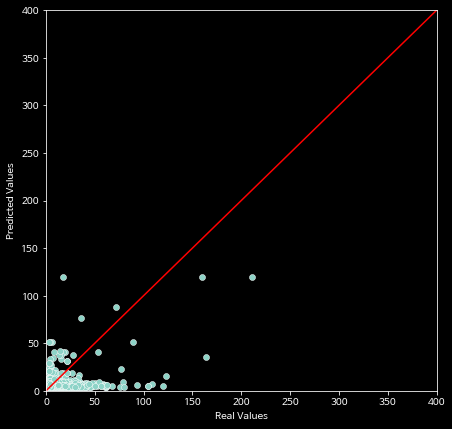

In [ ]:
# 성능이 좋지 않기 때문에 해당 지역에 평균 배송량을 사용하는 것이 더 유리할 것으로 판단됨
# 머신러닝 모형을 이용하기 위해서는 추가적인 변수를 수집하거나 물품 카테고리별 모형 세분화하는 방식으로 진행
sns.scatterplot(result['Real Values'], result['Predicted Values'])
plt.xlim(0, 400)
plt.ylim(0, 400)

x = [0, 400]
y = [0, 400]
plt.plot(x, y, color='red')
plt.gcf().set_size_inches(7 ,7)

#### 2) 중요 변수 파악

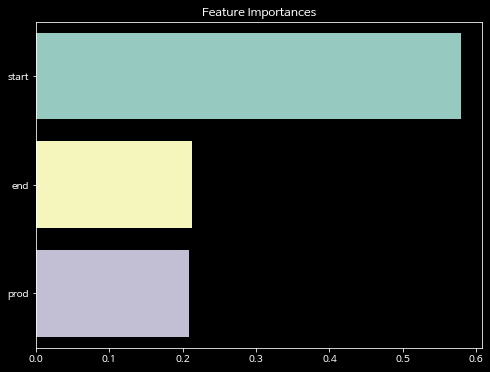

In [ ]:
# 출발지 >>> 도착지 > 물품 카테고리
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfr.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr, y=ftr.index)
plt.show()

#### 3) 모델 Save and Read

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfr)

# 모델 Read
# rfr_from_pickle = pickle.loads(saved_model)